In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [4]:
# read in raw data
culture_data=pd.read_csv('simulation_data/zinser_figure2a.csv')
# read psd data (Qc in fg C/cell)
psd_data=pd.read_csv('simulation_data/zinser_psd.csv')

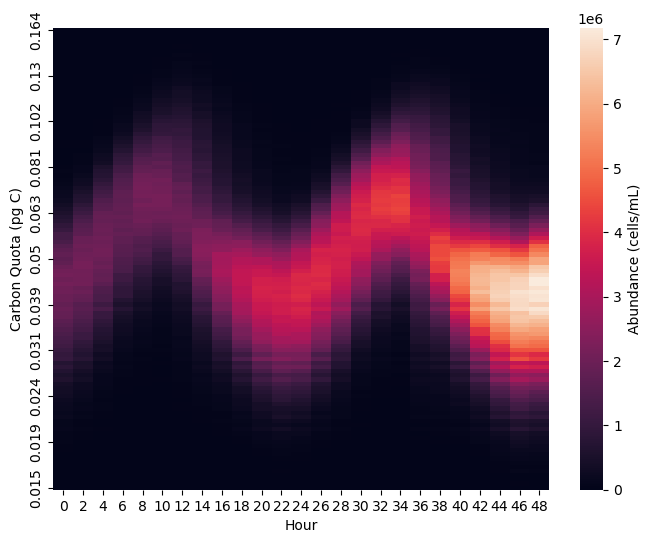

In [5]:
from matplotlib.ticker import StrMethodFormatter

# plot heat map of psd data
X = list(culture_data['exper time'])
Y = list(np.round(psd_data.columns[1:].astype(float)/1000,3))
# psd_data without the first col
Z = psd_data.iloc[:,1:].T.to_numpy()

# make new dataframe and plt
df = pd.DataFrame(data=Z, columns=X, index=Y)
df.sort_index(level=1, inplace=True,ascending=False)
# draw heat map
fig,axs=plt.subplots(figsize=(8,6))
# plot
s=sns.heatmap(df, square=False, yticklabels=11, cbar_kws={'label': 'Abundance (cells/mL)'})
s.set(xlabel='Hour', ylabel='Carbon Quota (pg C)')
# Round ytick labels
plt.rcParams.update({'font.size':15})
plt.show()

In [6]:
[i for i in axs.get_yticklabels()]

[Text(0, 0.5, '0.164'),
 Text(0, 11.5, '0.13'),
 Text(0, 22.5, '0.102'),
 Text(0, 33.5, '0.081'),
 Text(0, 44.5, '0.063'),
 Text(0, 55.5, '0.05'),
 Text(0, 66.5, '0.039'),
 Text(0, 77.5, '0.031'),
 Text(0, 88.5, '0.024'),
 Text(0, 99.5, '0.019'),
 Text(0, 110.5, '0.015')]

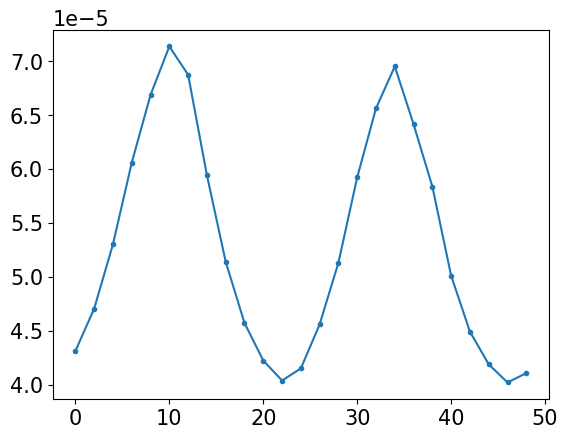

In [7]:
# plot mean Qc per time point
test=df.reset_index()
test.rename(columns={'index':'size_bin'},inplace=True)
test_long=pd.melt(test, id_vars=['size_bin'], var_name='hour', value_name='abundance')
test_long['Qc_sum'] = test_long['size_bin'] * test_long['abundance']
psd_long = test_long[test_long.abundance > 0]
# group by cruise and date to get n and summed qc by the hour
test_group = psd_long.groupby(['hour']).agg({
    'abundance': ['sum', 'median', 'mean'],
    'Qc_sum': 'sum'
 }).reset_index()
# fix column names
test_group.columns = [' '.join(col).strip() for col in test_group.columns.values]
# get mean Qc per hour and convert Qc from fg -> pg
test_group['Qc_hour'] = (test_group['Qc_sum sum']/test_group['abundance sum'])/1000
plt.plot(test_group['hour'],test_group['Qc_hour'],marker='.')
plt.set_ylabel='Hourly Averaged Qc (pg C/cell)'
plt.rcParams.update({'font.size':15})

In [8]:
# max_test=test_long[test_long['abundance']>0]
# max_test.groupby('hour').agg({'size_bin':['max','min']})

### Run TSD by STL

In [11]:
from statsmodels.tsa.seasonal import STL
# first subset data into what we care about
pro_data=test_group[['hour','Qc_hour']]
# get PAR data
ds = xr.open_dataset('/Users/Kathy/Desktop/UW/seaflow/decomposition_project/simulation_data/zinser_processed.nc',
                    decode_times=False)
pro_data['par']=ds.PAR.values
# set biomass values
pro_data['biomass']=ds['abundance'].values * pro_data['Qc_hour']

/var/folders/x3/sy2cc75s04157vygzwcwbbzr0000gn/T/ipykernel_42414/2270104171.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pro_data['par']=ds.PAR.values
/var/folders/x3/sy2cc75s04157vygzwcwbbzr0000gn/T/ipykernel_42414/2270104171.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pro_data['biomass']=ds['abundance'].values * pro_data['Qc_hour']


In [13]:
gt = xr.open_dataset('/Users/Kathy/Desktop/UW/seaflow/decomposition_project/simulation_data/zinser_ground_truth.nc',
                    decode_times=False)

/Users/Kathy/anaconda3/envs/seaflow/lib/python3.8/site-packages/pandas/core/indexing.py:1678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = empty_value


Text(0, 0.5, 'Qc (pg C/cell*hour)')

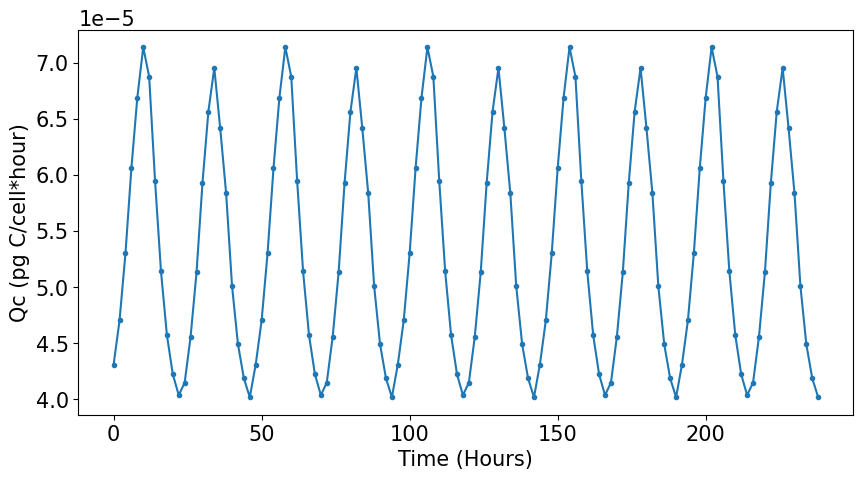

In [14]:
# add carbon loss
pro_data.loc[0:23,'carbonloss']=gt.carbonloss.values/1000
ten_days=pd.concat([pro_data[:-1]]*5).reset_index().drop(columns=['index'])
ten_days['hour']=np.arange(0,len(ten_days)*2,2)
fig,axs=plt.subplots(figsize=(10,5))
axs.plot(ten_days['hour'],ten_days['Qc_hour'],marker='.')
axs.set_xlabel('Time (Hours)')
axs.set_ylabel('Qc (pg C/cell*hour)')

RMSE: 0.00042617121493049114


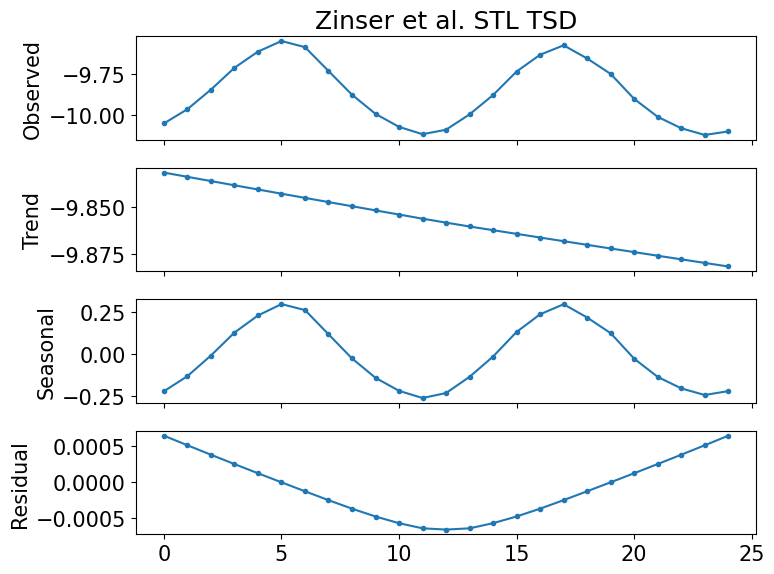

In [15]:
# stl_proolution is every other hour for 2 days, we care about daily cycle (period is 12 instead of 24)
fit_pro = STL(np.log(pro_data['Qc_hour']), period=12,robust=True)
stl_pro = fit_pro.fit()

fig,axs=plt.subplots(nrows=4,ncols=1,figsize=(8,6),sharex=True)
# plot observed subplot
stl_pro.observed.plot(ax=axs[0],marker='.')
axs[0].set_ylabel('Observed')
# plot trend subplot
stl_pro.trend.plot(ax=axs[1], legend=False,marker='.')
axs[1].set_ylabel('Trend')
stl_pro.seasonal.plot(ax=axs[2], legend=False,marker='.')
axs[2].set_ylabel('Seasonal')
# plot stl_proidual `sub1plot
stl_pro.resid.plot(ax=axs[3], legend=False,marker='.')
axs[3].set_ylabel('Residual')
axs[0].set_title(f"Zinser et al. STL TSD")
plt.rcParams.update({'font.size':15})
plt.tight_layout()

# print error
y_true=stl_pro.observed
y_pred=stl_pro.trend+stl_pro.seasonal
rmse=mean_squared_error(y_true, y_pred,squared=False)
print(f'RMSE: {rmse}')
### RMSE is lower when robust=True for OG time series, False for extended (10 days)

### calculate hourly growth from diel component

In [16]:
## helper function to do a centered difference to calculate growth rate, edges calculated by first order diff
# input: df=dataframe with diel component, col=specififying diel component of particular model, spacing=scalar to 
# indicate spacing between values
def centered_diff(df,col,spacing):
    return(pd.Series(np.gradient(df[col],spacing), name='hourly_growth'))

def forward_diff(df,col,spacing):
    return(pd.Series(np.diff(df[col])/spacing, name='hourly_growth'))

def exp_growth(df,col,spacing):
    return(np.log(df[col]/df[col].shift())/spacing)

In [17]:
pro_data['trend']=np.exp(stl_pro.trend)
pro_data['diel']=np.exp(stl_pro.seasonal)
pro_data['resid']=np.exp(stl_pro.resid)
spacing=np.mean(pro_data.diff()['hour'])
pro_data['hourly_growth']=forward_diff(pro_data.set_index('hour'),'diel',spacing)
pro_data['exp_growth']=exp_growth(pro_data,'diel',spacing)
# adjust for negative growth (impute as 0)
pro_data['adj_growth']= np.where(pro_data['hourly_growth']<0,pro_data['hourly_growth']==0,pro_data['hourly_growth'])
pro_data['exp_growth']= np.where(pro_data['exp_growth']<0,pro_data['exp_growth']==0,pro_data['exp_growth'])

Text(0.5, 0, 'Time (hours)')

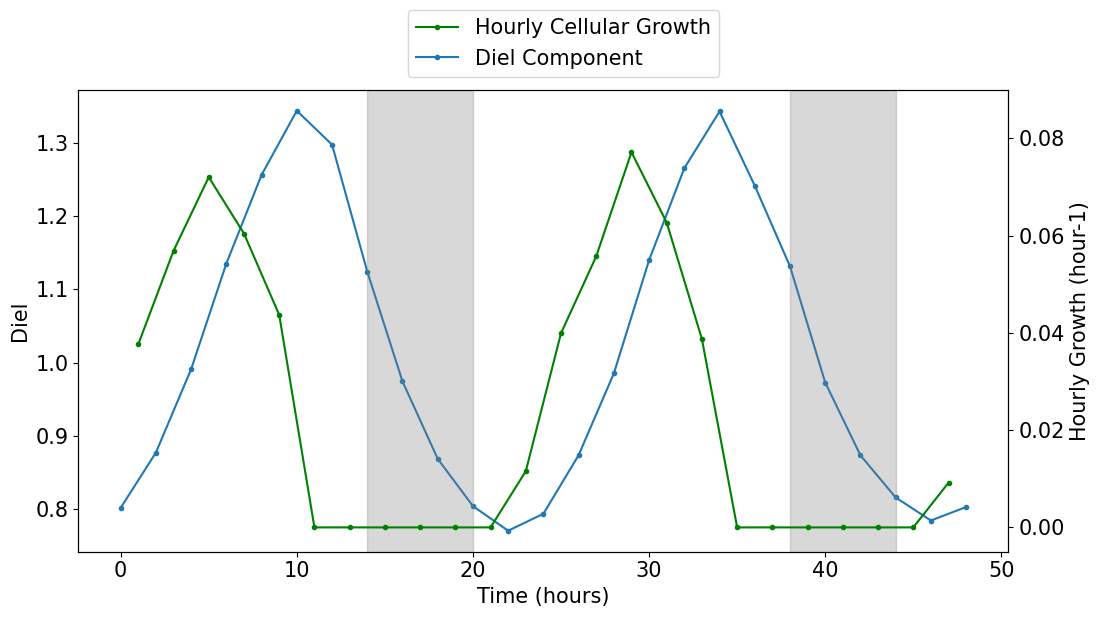

In [20]:
# plot calculated hourly growth 
fig,axs=plt.subplots(figsize=(12,6))
# plot hourly Qc
ln3=axs.plot(pro_data['hour'],pro_data['diel'],marker='.', label='Diel Component')
# make secondary axis
twinax=axs.twinx()
# plot hourly growth
ln1=twinax.plot(pro_data['hour']+1,pro_data['adj_growth'],marker='.',label='Hourly Cellular Growth',c='g')
#ln2=twinax.plot(pro_data['hour']+1,pro_data['culture_PP'],marker='.',label='Culture PP',c='orange')
# fill in night and day
twinax.fill_between(pro_data['hour'], 0, 1, 
                    where=pro_data['par'] == 0,color='gray', alpha=0.3, transform=twinax.get_xaxis_transform())
# axs.set_ylim(-0.005,0.08)
twinax.set_ylim(-0.005,0.09)
# make legend
lns = ln1+ln3
labs = [l.get_label() for l in lns]
axs.legend(lns, labs,loc='center right', bbox_to_anchor=(0.7, 1.1))
# axis labels
axs.set_ylabel('Diel')
twinax.set_ylabel('Hourly Growth (hour-1)')
axs.set_xlabel('Time (hours)')

# twinax.tick_params(left=False, labelleft=False, top=False, labeltop=False,
#                right=False, labelright=False, bottom=False, labelbottom=False)
    
#axs.set_title('TSD Estimated Growth vs. Hourly Qc')

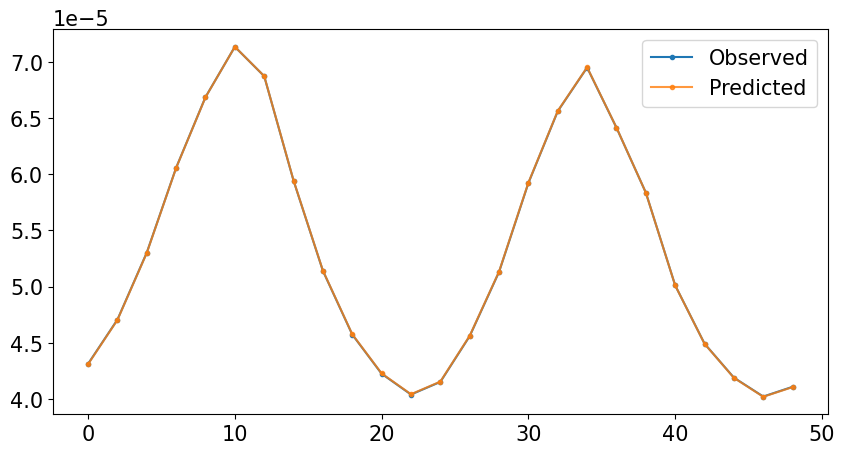

In [21]:
y_pred=pro_data['diel']*pro_data['trend']
fig,axs=plt.subplots(figsize=(10,5))
# plot observed
axs.plot(pro_data['hour'],pro_data['Qc_hour'],marker='.',label='Observed')
axs.plot(pro_data['hour'],y_pred,marker='.',alpha=0.8,label='Predicted')
axs.legend()
# pretty good match 

### Compare calculated hourly growth with PP
First, compare raw TSD output. Then, use Webb model (the model Zinser paper chose) results to compare.

In [16]:
# which columns are the ground truth?
# culture_results[['Time of day','PP','alpha', 'Pmax']]

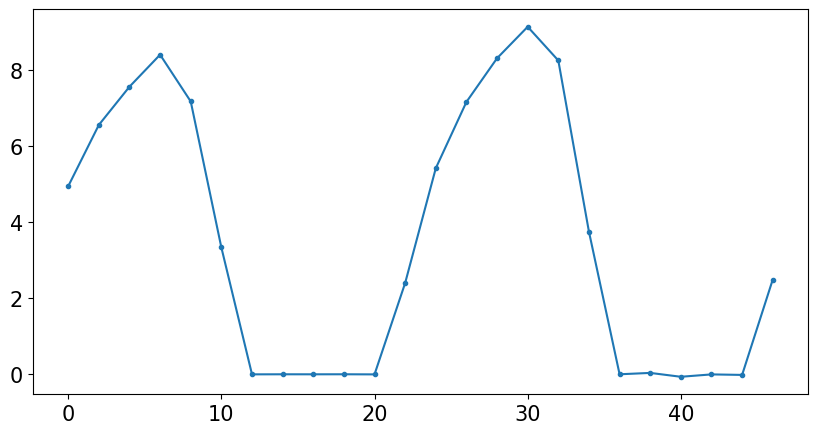

In [30]:
culture_results=pd.read_csv("data/zinser_figure3.csv")
# simulate data for culture results 
pro_data_culture=pd.concat([culture_results[:-1]]*1).reset_index().drop(columns=['index'])
pro_data_culture['hour']=np.arange(0,len(pro_data_culture)*2,2)
fig,axs=plt.subplots(figsize=(10,5))
axs.plot(pro_data_culture['hour'],pro_data_culture['PP'],marker='.')

Text(0.5, 1.0, 'TSD Estimated Growth vs. 14C Estimated Photosynthesis')

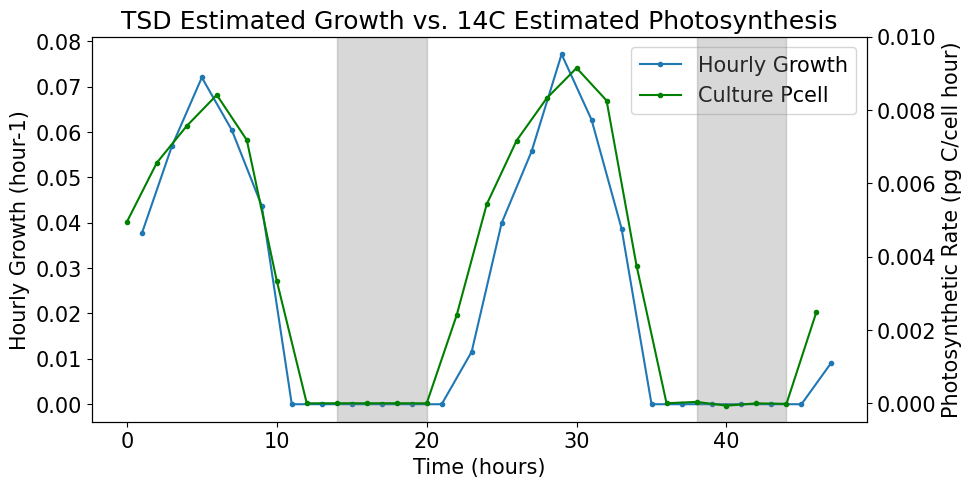

In [31]:
# convert from fg to pg
pro_data['culture_PP']=pro_data_culture['PP']/1000
# plot pp
fig,axs=plt.subplots(figsize=(10,5))
# plot primary production estimated from culture
ln1=axs.plot(pro_data['hour']+1,pro_data['adj_growth'],marker='.',label='Hourly Growth')
# ln2=axs.plot(pro_data['hour']+1,pro_data['exp_growth'],marker='.',label='Exponential Growth')
# make secondary axis
twinax=axs.twinx()
ln3=twinax.plot(pro_data['hour'],pro_data['culture_PP'],marker='.',c='g', label='Culture Pcell')
twinax.set_ylim(-0.0005,0.01)
# twinax.set_ylim(-0.085,0.07)
# fill in night and day
twinax.fill_between(pro_data['hour'], 0, 1, 
                    where=pro_data['par'] == 0,color='gray', alpha=0.3, transform=twinax.get_xaxis_transform())
# make legend
lns = ln1+ln3
labs = [l.get_label() for l in lns]
axs.legend(lns, labs,loc='upper right')
# axis labels
axs.set_ylabel('Hourly Growth (hour-1)')
twinax.set_ylabel('Photosynthetic Rate (pg C/cell hour)')
axs.set_xlabel('Time (hours)')
axs.set_title('TSD Estimated Growth vs. 14C Estimated Photosynthesis')

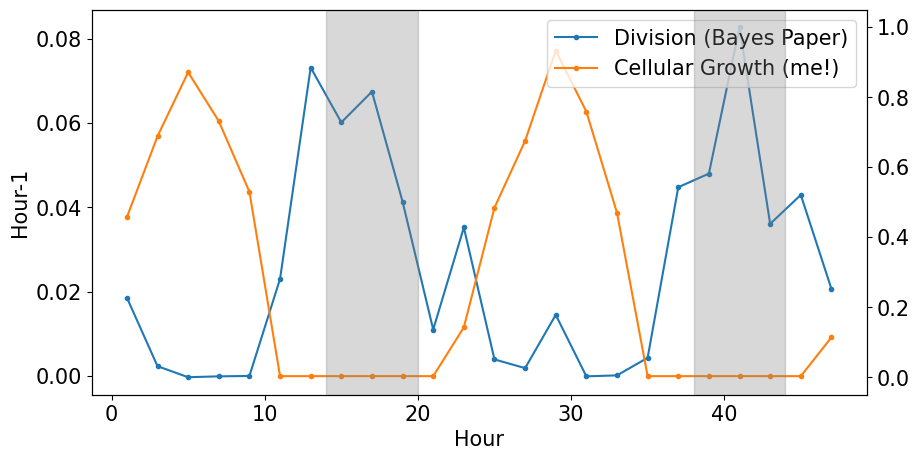

In [32]:
# plot cell division
fig,axs=plt.subplots(figsize=(10,5))
# plot culture calculated division 
ln1=axs.plot(gt['division_time'],gt['division'],marker='.', label='Division (Bayes Paper)')
# plot my calculated growth
ln2=axs.plot(pro_data['hour']+1,pro_data['adj_growth'],marker='.',label='Cellular Growth (me!)')
axs.set_ylabel('Hour-1')
axs.set_xlabel('Hour')
twinax=axs.twinx()
twinax.fill_between(pro_data['hour'], 0, 1, 
                    where=pro_data['par'] == 0,color='gray', alpha=0.3, transform=twinax.get_xaxis_transform())
lns=ln1+ln2
labs = [l.get_label() for l in lns]
axs.legend(lns, labs,loc='upper right')

#### Compare rate of change together

Text(0.5, 1.0, 'TSD Estimated Growth vs. 14C Estimated Photosynthesis')

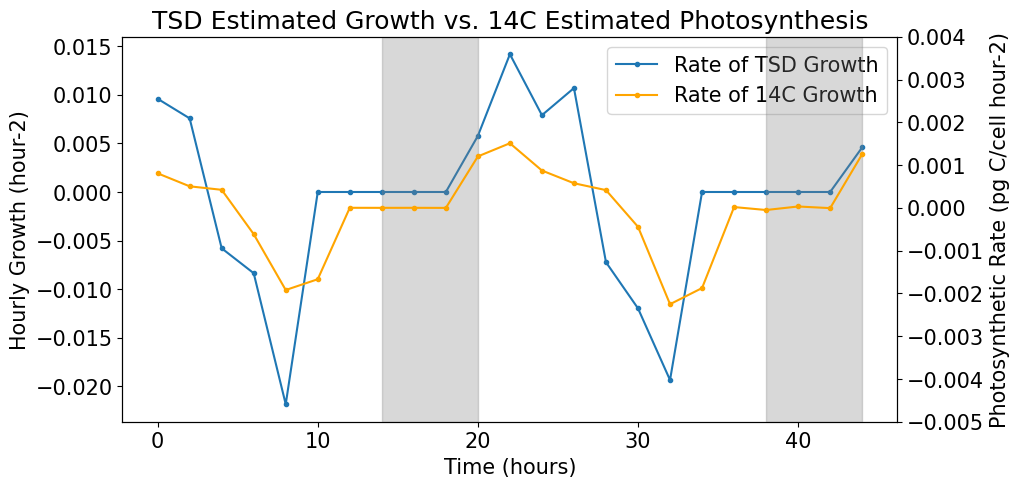

In [33]:
tsd_growth=forward_diff(pro_data, 'adj_growth', spacing)
c14_growth=forward_diff(pro_data, 'culture_PP', spacing)
# plot
fig,axs=plt.subplots(figsize=(10,5))
# plot primary production estimated from culture
ln1=axs.plot(pro_data[:-1]['hour'],tsd_growth,marker='.',label='Rate of TSD Growth')
# make secondary axis
twinax=axs.twinx()
ln2=twinax.plot(pro_data[:-1]['hour'],c14_growth,marker='.',c='orange', label='Rate of 14C Growth')
twinax.set_ylim(-0.005,0.004)
# twinax.set_ylim(-0.085,0.07)
# fill in night and day
twinax.fill_between(pro_data['hour'], 0, 1, 
                    where=pro_data['par'] == 0,color='gray', alpha=0.3, transform=twinax.get_xaxis_transform())
# make legend
lns = ln1+ln2
labs = [l.get_label() for l in lns]
axs.legend(lns, labs,loc='upper right')
# axis labels
axs.set_ylabel('Hourly Growth (hour-2)')
twinax.set_ylabel('Photosynthetic Rate (pg C/cell hour-2)')
axs.set_xlabel('Time (hours)')
axs.set_title('TSD Estimated Growth vs. 14C Estimated Photosynthesis')

#### Compare by dividing C-fixation by biomass

Text(0.5, 0, 'Time (hours)')

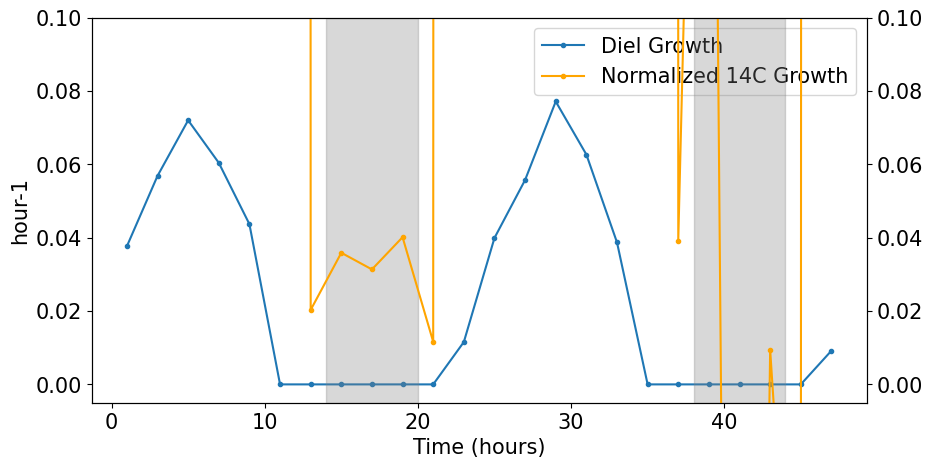

In [34]:
# try average (x2)
norm_PP=pro_data['culture_PP']/(np.mean(pro_data['Qc_hour'])*2)
# plot
fig,axs=plt.subplots(figsize=(10,5))
# plot TSD estimated growth
ln1=axs.plot(pro_data['hour']+1,pro_data['adj_growth'],marker='.',label='Diel Growth')
# make secondary axis
twinax=axs.twinx()
ln2=twinax.plot(pro_data['hour']+1,norm_PP,marker='.',c='orange', label='Normalized 14C Growth')
axs.set_ylim(-0.005,0.1)
twinax.set_ylim(-0.005,0.1)
# twinax.set_ylim(-0.085,0.07)
# fill in night and day
twinax.fill_between(pro_data['hour'], 0, 1, 
                    where=pro_data['par'] == 0,color='gray', alpha=0.3, transform=twinax.get_xaxis_transform())
# make legend
lns = ln1+ln2
labs = [l.get_label() for l in lns]
axs.legend(lns, labs,loc='upper right')
# axis labels
axs.set_ylabel('hour-1')

axs.set_xlabel('Time (hours)')
#axs.set_title('TSD Estimated Growth vs. 14C Estimated Photosynthesis')

#### Compare by multipling hourly growth by trend (Qc)

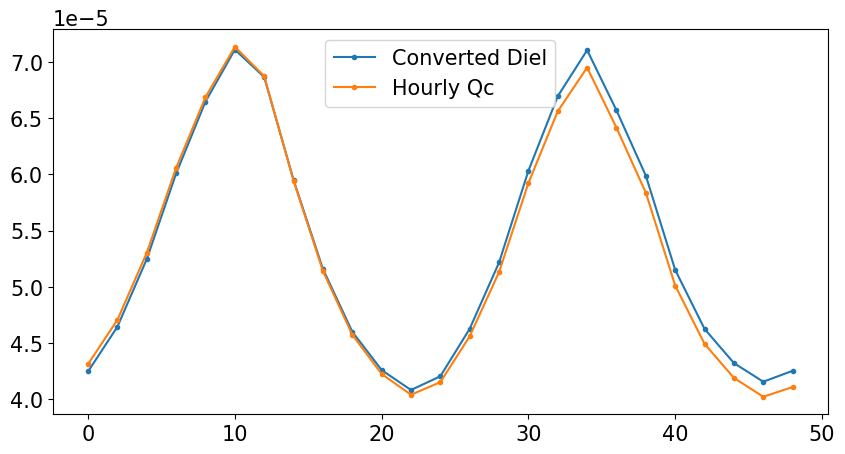

In [37]:
# get mean Qc over entire experiment (paper mentioned 0.053 pg C, but this # seems to be from another study)
## fix this later so that i get the mean across the entire psd
mean_qc=np.mean(pro_data['Qc_hour'])
# I also get ~0.053 which is good
diel_qc=(mean_qc)*pro_data['diel']
fig,axs=plt.subplots(figsize=(10,5))
axs.plot(pro_data['hour'],diel_qc,marker='.', label='Converted Diel')
axs.plot(pro_data['hour'],pro_data['Qc_hour'],marker='.', label='Hourly Qc')

axs.legend()

Text(0.5, 0, 'Hour')

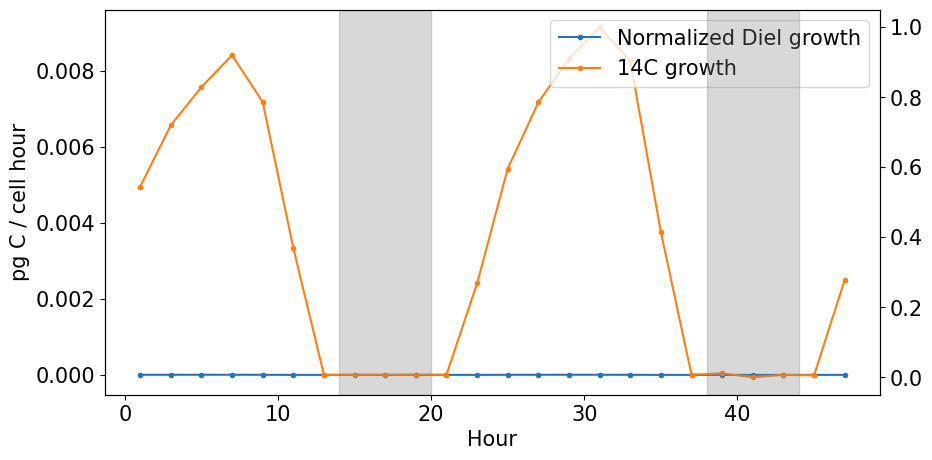

In [38]:
# calculate growth from diel_qc
pro_data['adj_diel']=diel_qc
pro_data['diel_growth']=forward_diff(pro_data, 'adj_diel',spacing)
pro_data['diel_growth']=np.where(pro_data['diel_growth']<0,pro_data['diel_growth']==0,pro_data['diel_growth'])
# plot 
fig,axs=plt.subplots(figsize=(10,5))
axs.plot(pro_data['hour']+1, pro_data['diel_growth'], label='Normalized Diel growth',marker='.')
axs.plot(pro_data['hour']+1, pro_data['culture_PP'], label='14C growth',marker='.')
twinax=axs.twinx()
twinax.fill_between(pro_data['hour'], 0, 1, 
                    where=pro_data['par'] == 0,color='gray', alpha=0.3, transform=twinax.get_xaxis_transform())
axs.legend(loc='upper right')
axs.set_ylabel('pg C / cell hour')
axs.set_xlabel('Hour')

In [40]:
# calculate means of net productivity
#### carbon loss term comes from estimates from Bayesian MPM model paper, NOT zinser measurements ###
net_PP=pro_data['culture_PP']-pro_data['carbonloss']
net_PP_hours=pro_data.hour.values
pro_data['net_PP']=net_PP
# # calculate new standard deviation from summed variances of fixation and loss
# c14_error=np.sqrt(np.square(gt['carbonfix_sd'][:-1].values/1000)+
#                   np.square(gt['carbonloss_sd'].values/1000))
# rel_error=c14_error/net_PP

In [42]:
zinser_fig2a=pd.read_csv('simulation_data/zinser_figure2a.csv')
abundance_mean = 0.5 * (zinser_fig2a['cells A'].values + zinser_fig2a['cells B'].values)
# correct abundance mean to only increase with time
for i in range(1, abundance_mean.size):
        abundance_mean[i] = max(abundance_mean[i-1], abundance_mean[i])

# get observation times and change in time
obs_time_hours = zinser_fig2a['exper time'].values        
dt = obs_time_hours[1] - obs_time_hours[0]

import netCDF4 as nc4
# get size data from size distribution
with nc4.Dataset('simulation_data/zinser_processed.nc') as nc:
    w_obs = nc.variables['w_obs'][:]
    delta_v = 1.0/nc.variables['delta_v_inv'][:]
    v = nc.variables['v_min'][:].data * 2**(np.arange(nc.variables['m'][:])*delta_v)
    
# calculate net
cellsize = np.sum(v[:,None] * w_obs, axis=0)
net_bayes = (cellsize[1:]*(abundance_mean[1:]/abundance_mean[:-1]) - cellsize[:-1])/dt

Text(0.5, 1.0, 'TSD Estimated Growth vs. 14C Estimated Photosynthesis')

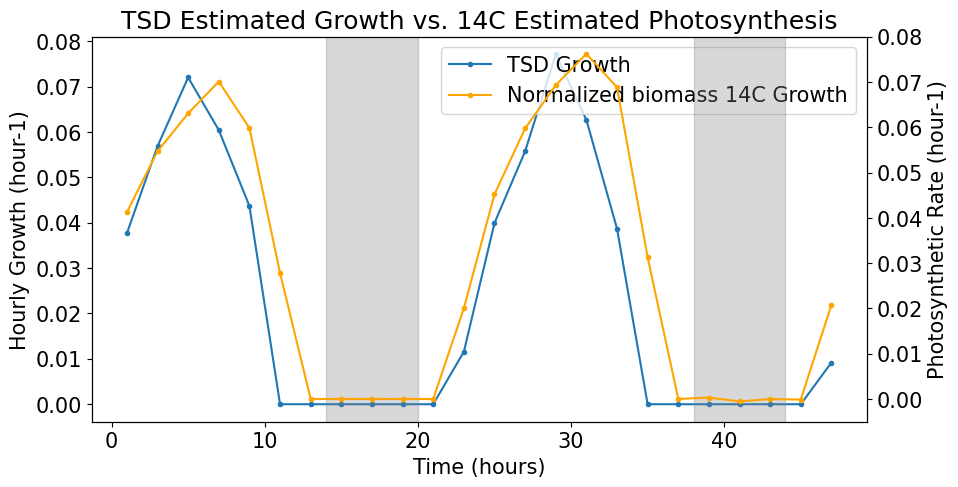

In [43]:
# try average
norm_PP=pro_data['culture_PP']/0.12
# plot
fig,axs=plt.subplots(figsize=(10,5))
# plot TSD estimated growth
ln1=axs.plot(pro_data['hour']+1,pro_data['adj_growth'],marker='.',label='TSD Growth')
# make secondary axis
twinax=axs.twinx()
ln2=twinax.plot(pro_data['hour']+1,norm_PP,marker='.',c='orange', label='Normalized biomass 14C Growth')
twinax.set_ylim(-0.005,0.08)
# twinax.set_ylim(-0.085,0.07)
# fill in night and day
twinax.fill_between(pro_data['hour'], 0, 1, 
                    where=pro_data['par'] == 0,color='gray', alpha=0.3, transform=twinax.get_xaxis_transform())
# make legend
lns = ln1+ln2
labs = [l.get_label() for l in lns]
axs.legend(lns, labs,loc='upper right')
# axis labels
axs.set_ylabel('Hourly Growth (hour-1)')
twinax.set_ylabel('Photosynthetic Rate (hour-1)')
axs.set_xlabel('Time (hours)')
axs.set_title('TSD Estimated Growth vs. 14C Estimated Photosynthesis')

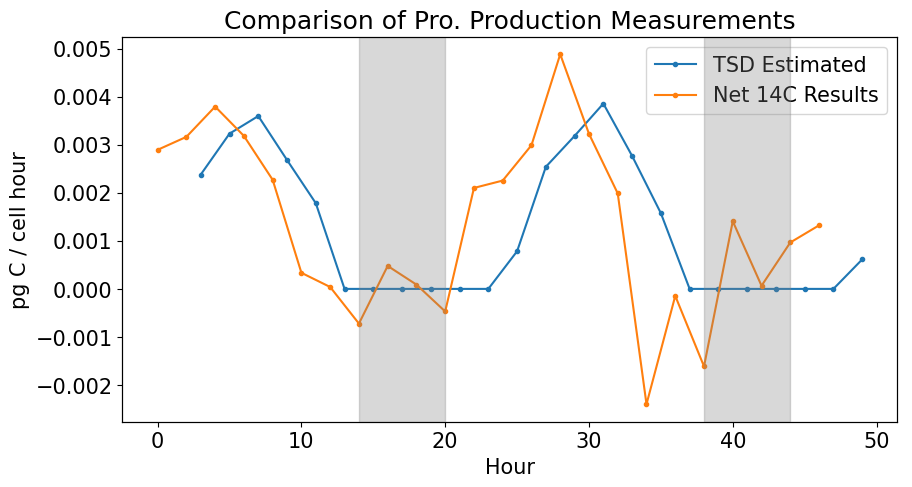

In [49]:
# plot the range of diel growth
min_trend=np.min(pro_data['trend'])
max_trend=np.mean(pro_data['Qc_hour'])
# calculate growth
pro_data['min_diel']=min_trend*pro_data['diel']
pro_data['max_diel']=max_trend*pro_data['diel']
pro_data['min_diel_growth']=forward_diff(pro_data, 'min_diel',spacing)
pro_data['max_diel_growth']=exp_growth(pro_data, 'max_diel',spacing)
pro_data['min_diel_growth']=np.where(pro_data['min_diel_growth']<0,
                                     pro_data['min_diel_growth']==0,
                                     pro_data['min_diel_growth'])
pro_data['max_diel_growth']=np.where(pro_data['max_diel_growth']<0,
                                     pro_data['max_diel_growth']==0,
                                     pro_data['max_diel_growth'])
# plot
fig,axs=plt.subplots(figsize=(10,5))
# axs.plot(pro_data['hour'], pro_data['min_diel_growth'], label='Min Diel growth',marker='.')
# plot tsd data
axs.plot(pro_data['hour']+1, pro_data['max_diel_growth']*0.053, label='TSD Estimated',marker='.')
# plot 14C data (fixation-loss)
axs.plot(net_PP_hours, net_PP, label='Net 14C Results',marker='.')
# plot 14C data (directly calculated Net)

# plot uncertainty
# axs.fill_between(net_PP_hours, net_PP-c14_error, net_PP+c14_error, color = 'orange', alpha=0.2, 
#                  label=r'$\sigma_{net}$')
twinax=axs.twinx()
twinax.fill_between(pro_data['hour'], 0, 1, 
                    where=pro_data['par'] == 0,color='gray', alpha=0.3, transform=twinax.get_xaxis_transform())
axs.legend()
axs.set_ylabel('pg C / cell hour')
axs.set_xlabel('Hour')
axs.set_title('Comparison of Pro. Production Measurements')
# hide dumb secondary axis labels
yax = twinax.get_yaxis()
yax = yax.set_visible(False)

In [ ]:
# plot carbonloss
fig,axs = plt.subplots(figsize=(10,6))

In [25]:
lab_results=pd.DataFrame([np.rint(net_PP_hours), net_PP]).T
lab_results.columns=['hour','14C_net']
lab_results['hour']=lab_results['hour'].astype(int)
# make copy
rates_df=pro_data.copy()
rates_df['hour']+=1
all_rates=rates_df.merge(lab_results)

In [26]:
day_only=all_rates.loc[all_rates['par']>0]

In [ ]:
# print error
y_true=day_only['14C_net']
y_pred=day_only['max_diel_growth']
rmse=mean_squared_error(y_true, y_pred,squared=False)
print(f'RMSE: {rmse}')

corr_matrix = np.corrcoef(y_true, y_pred)
corr = corr_matrix[0,1]
R_sq = corr**2
print(f'R2: {R_sq}')

In [ ]:
# getting uncertainty of blue line (TSD values) by block bootstrapping

### wow i cant believe that's all it took to work wow

In [77]:
gt['carbonfix']

<xarray.DataArray 'carbonfix' (carbonfix_time: 25)>
array([ 4.948369e+00,  6.556686e+00,  7.574984e+00,  8.414698e+00,
        7.187658e+00,  3.340287e+00,  1.962333e-03,  4.079040e-03,
        3.260743e-03,  3.929278e-03,  1.238224e-03,  2.406456e+00,
        5.429406e+00,  7.170946e+00,  8.322522e+00,  9.152088e+00,
        8.265402e+00,  3.750739e+00,  4.152097e-03,  4.005195e-02,
       -2.800356e-04,  7.095304e-04, -1.809134e-05,  2.494738e+00,
        4.389839e+00])
Coordinates:
  * carbonfix_time  (carbonfix_time) int64 1 3 5 7 9 11 13 ... 39 41 43 45 47 49
Attributes:
    long_name:  cell carbon fixation rate
    units:      fg C cell$^{-1}$ h$^{-1}$

In [76]:
gt['carbonloss']

<xarray.DataArray 'carbonloss' (carbonloss_time: 24)>
array([ 2.056878,  3.400864,  3.777101,  5.229221,  4.912528,  3.005733,
       -0.037101,  0.725385, -0.47454 , -0.084751,  0.470916,  0.304904,
        3.171089,  4.179562,  3.436023,  5.920266,  6.273661,  6.154495,
        0.149444,  1.652845, -1.468653, -0.064447, -0.978152,  1.173173])
Coordinates:
  * carbonloss_time  (carbonloss_time) int64 1 3 5 7 9 11 ... 37 39 41 43 45 47
Attributes:
    long_name:  cell carbon loss rate
    units:      fg C cell$^{-1}$ h$^{-1}$

Text(0.5, 0, '14C Production')

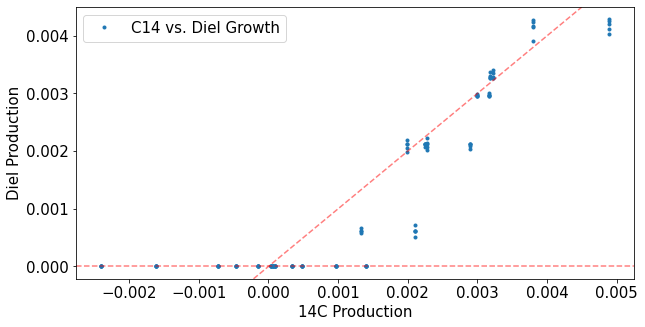

In [64]:
# compare the two
fig,axs=plt.subplots(figsize=(10,5))
axs.plot(net_PP, ten_days['max_diel_growth'], label='C14 vs. Diel Growth',marker='.',linestyle='')
axs.axhline(y=0, linestyle='--', color='r',alpha=0.5)
axs.axline((0, 0), (0.004, 0.004), linestyle='--', color='r',alpha=0.5)
#axs.plot(pro_data['hour'], , label='14C growth',marker='.')
# twinax=axs.twinx()
# twinax.fill_between(pro_data['hour'], 0, 1, 
#                     where=pro_data['par'] == 0,color='gray', alpha=0.3, transform=twinax.get_xaxis_transform())
axs.legend()
axs.set_ylabel('Diel Production')
axs.set_xlabel('14C Production')

### Integrating to get gross production

In [37]:
# when culture_PP is negative, reset
ten_days.loc[:6,'day']=1
ten_days.loc[7:18,'day']=2
ten_days.loc[19:,'day']=3

In [82]:
from scipy import integrate
total_int_PP=0
total_TSD_PP=0
total_int_nPP = 0
for day in pd.unique(ten_days['day'])[:-1]:
    sub=ten_days.loc[ten_days['day']==day]
    y1=sub['culture_PP']
    y2=sub['max_diel_growth']
    y3=sub['net_PP']
    x=sub['hour']+1
    daily_gross=integrate.trapezoid(y1,x)
    TSD_gross=integrate.trapezoid(y2,x)
    net_intg = integrate.trapezoid(y3,x)
    print(f'14C Gross: {daily_gross}, TSD Gross: {TSD_gross}, Net PP: {net_intg}')
    print(f'% Difference in gross v. net: {TSD_gross/daily_gross}')
    total_int_PP+=daily_gross
    total_TSD_PP+=TSD_gross
    total_int_nPP += net_intg

14C Gross: 0.07108995, TSD Gross: 0.026872573102776107, Net PP: 0.028419278370229756
% Difference in gross v. net: 0.37800804618340716
14C Gross: 0.08898515, TSD Gross: 0.030549810457101048, Net PP: 0.029407072467024384
% Difference in gross v. net: 0.34331358049181293


In [83]:
avg_gpp = total_int_PP/2
avg_npp = total_int_nPP/2
avg_npp/avg_gpp

0.3612451332983964

In [78]:
53/82.5

0.6424242424242425

In [131]:
# % TSD estimated PP of total gross PP
## fraction of TSD estimated compared to total estimated gross 14C measurements
(total_TSD_PP/total_int_PP)

0.3552254241950791

In [42]:
total_TSD_PP

0.05742238355987715

In [41]:
total_int_PP

0.1600751

In [40]:
total_int_nPP

0.05782635083725414

In [134]:
(82.5-53)/82.5

0.3575757575757576

In [158]:
(83-53)/83

0.3614457831325301

In [159]:
(82-53)/82

0.35365853658536583

In [703]:
y=pro_data.loc[0:2,'culture_PP']
x=pro_data.loc[0:2, 'hour']
integrate.trapezoid(y,x,dx=2)

0.0256483

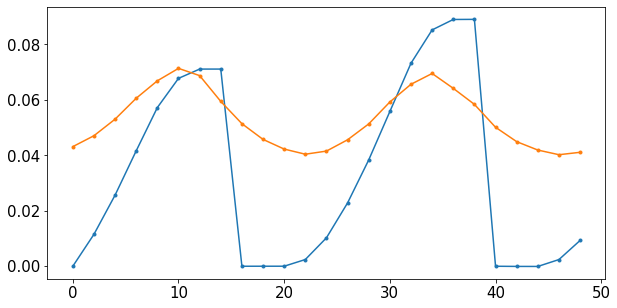

In [708]:
# integrate across 14C data and time
from scipy import integrate
int_PP=[]
# loop thru each "day"
for day in pd.unique(pro_data['day']):
    # get subset of data
    y=pro_data.loc[pro_data['day']==day,'culture_PP']
    # y=pro_data['adj_growth']
    x=pro_data.loc[pro_data['day']==day,'hour']
    int_PP.append(integrate.cumtrapz(y, x,initial=0,dx=spacing))
fig,axs=plt.subplots(figsize=(10,5))
flat_PP=[item for sublist in int_PP for item in sublist]
axs.plot(pro_data['hour'],flat_PP,marker='.')
axs.plot(pro_data['hour'],pro_data['Qc_hour'],marker='.')

### Calculate growth parameters with Platt equation

In [32]:
from scipy.optimize import curve_fit
import math

# helper function to find the closest value in a list
def closest(lst, K):     
    return lst[min(range(len(lst)), key = lambda i: abs(lst[i]-K))]

# platt equation (no photoinhibition)
## KI=half saturation constant, where light = 1/2P
def platt1(x, p_max, ki):
    return (p_max*x)/(ki+x)

# platt equation (with photoinhibition)
def platt2(i, p_max, alpha,beta):
    return (p_max*(1-math.e**(-alpha*i/p_max))*math.e**(-beta*i/p_max))

# exponential (no photoinhibition)
def exponential_pe(i, p_max, alpha):
    return (p_max*(1-math.e**(-alpha*i/p_max)))

# helper function to optimize platt equation where x=par, y=growth rate
def optimize_pi(x, y, method="platt1"):
    # set initial guess params for pmax
    p_max=np.max(y)
    if method=="platt1":
        ki=x[y[y==p_max].index].values[0]/2
        # call curve fit and set initial params to guesses of best fit per day
        ## initialized values MUST fit within bounds or else this will fail! ##
        parameters, covariance=curve_fit(platt1, list(x), list(y), p0=[p_max, ki],bounds=(0, [0.3,1500]))
        # fit parameters
        fit_p_max = parameters[0]
        fit_ki = parameters[1]
        # fit model to new parameters
        fit_platt = platt1(x, fit_p_max, fit_ki)
    elif method=="platt2":
        # set photoinhibition after pmax
        pmax_i=x[y[y==p_max].index].values[0]
        # set to some scale first
        alpha=0.00005
        beta=0.00005
        parameters, covariance=curve_fit(platt2, 
                                         list(x), 
                                         list(y),
                                         p0=[p_max,alpha,beta],
                                         bounds=(0, [0.3,alpha*10,beta*1000]))
        fit_p_max = parameters[0]
        fit_alpha = parameters[1]
        fit_beta = parameters[2]
        # fit model to new parameters
        fit_platt = platt2(x, fit_p_max, fit_alpha, fit_beta)
    else:
        print("Enter valid method")
        exit
    return fit_platt,parameters

In [34]:
# "days" in culture experiment
pro_data['night']='night'
pro_data.loc[:6, 'night']='day'
pro_data.loc[11:18, 'night']='day'
# set experiment days
day1=pro_data.loc[:6]
day2=pro_data.loc[11:16]

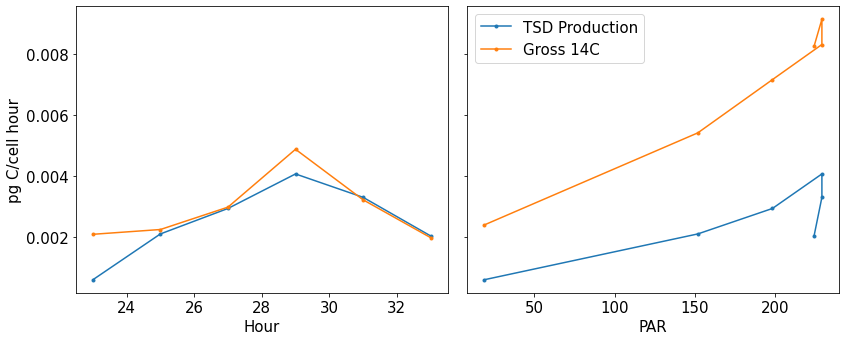

In [35]:
## work with day2 (only full day available)
# plot day2 data together
fig,axs=plt.subplots(ncols=2,figsize=(12,5),sharey=True)
axs[0].plot(day2['hour']+1, day2['max_diel_growth'],marker='.',label='TSD Production')
axs[0].plot(net_PP_hours[11:17], net_PP[11:17],marker='.', label='Net 14C Production')
axs[0].set_ylabel('pg C/cell hour')
axs[0].set_xlabel('Hour')

axs[1].plot(day2['par'], day2['max_diel_growth'],marker='.', label='TSD Production')
# axs[1].plot(day2['par'], net_PP[11:17],marker='.', label='Net 14C Production')
axs[1].plot(day2['par'], day2['culture_PP'],marker='.',label='Gross 14C ')
axs[1].set_xlabel('PAR')
axs[1].legend()

plt.tight_layout()

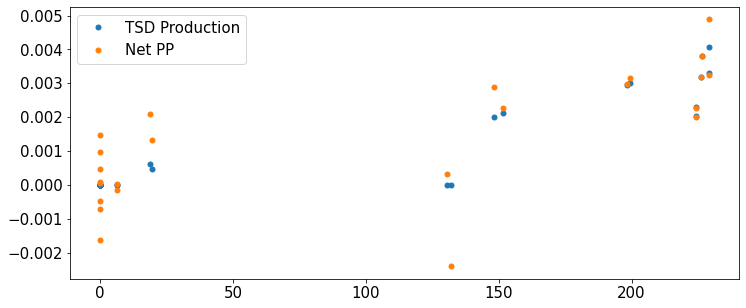

In [36]:
# plot all par PP
fig,axs=plt.subplots(figsize=(12,5),sharey=True)
axs.plot(pro_data['par'], pro_data['max_diel_growth'],marker='.', label='TSD Production', linestyle='',
         markersize=10)
axs.plot(pro_data['par'][:-1], net_PP,marker='.', label='Net PP', linestyle='',markersize=10)
axs.legend()

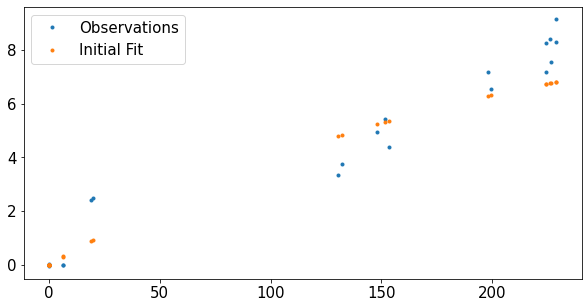

In [37]:
### see if i can replicate PP results from zinser data
# set initials and bounds (in fg)
init_pmax=10
# i think that's what francois told me
init_alpha=0.05
# using expoentnial equation + alpha + pmax + par, i should be able to get back PP
## these are initial results
culture_results['par']=pro_data['par']
x=culture_results['par']
back_PP=exponential_pe(x, init_pmax, init_alpha)
# plot
fig,axs=plt.subplots(figsize=(10,5))
axs.plot(x,culture_results['PP'], marker='.',label='Observations', linestyle='')
axs.plot(x,back_PP, marker='.', label='Initial Fit', linestyle='')
axs.legend()

In [40]:
# rewritten exponential (no photoinhibition) for least squares
## theta are params to test ([p_max, alpha])
def exponential_pe(theta, i):
    return (theta[0]*(1-math.e**(-theta[1]*i/theta[0])))

In [50]:
culture_results

,TimePoint,Time of day,PP,PP-sd,alpha,Alpha-sd,Pmax,Pmax-sd,Estar,Estar-sd,pmax,pmax-sd,Ek2,Ek2-sd,pPmax,pPmax-sd,par
0,1,8,4.95040,0.448400,0.0504,0.008840,6.7984,0.28720,136.6003,18.2991,0.9358,0.12540,1.0855,0.14540,0.727400,0.035200,148.279626
1,2,10,6.56400,0.735700,0.0533,0.013200,8.2158,0.59470,157.8867,28.1139,1.0894,0.19400,1.2637,0.22500,0.797800,0.031800,199.521423
2,3,12,7.56990,0.747100,0.0626,0.012500,9.3270,0.84460,150.7930,16.7895,1.2946,0.14410,1.5017,0.16720,0.811300,0.006630,226.445848
3,4,14,8.41240,0.330900,0.0745,0.013000,10.4038,0.37920,141.3992,19.6546,1.3782,0.19160,1.5988,0.22220,0.808600,0.002340,226.069041
4,5,16,7.18210,0.091600,0.0730,0.013600,9.6576,0.54610,134.0172,17.6720,1.4427,0.19020,1.6735,0.22070,0.744600,0.032600,224.277784
5,6,18,3.34030,0.203200,0.0804,0.013600,9.1964,0.54980,115.4351,12.6731,0.9751,0.10700,1.1311,0.12420,0.363200,0.000375,130.568642
6,7,20,0.00215,0.040900,0.0550,0.009550,6.3770,0.53840,117.0489,10.5715,0.0475,0.00429,0.0551,0.00498,0.000066,0.006410,6.449394
7,8,22,0.00380,0.019400,0.0658,0.000778,8.0491,0.13640,122.4871,3.5838,0.0000,0.00000,0.0000,0.00000,0.000492,0.002420,0.000000
8,9,0,0.00332,0.009290,0.0435,0.001980,5.2781,0.00474,121.5228,5.3696,0.0000,0.00000,0.0000,0.00000,0.000631,0.001760,0.000000
9,10,2,0.00425,0.021300,0.0380,0.000071,4.2388,0.06660,111.7985,1.9211,0.0000,0.00000,0.0000,0.00000,0.000963,0.005010,0.000000


In [67]:
from scipy import optimize
# actual values
y=pro_data['culture_PP']*1000
# par values
x=culture_results['par']
# initial values
init_pmax=10; init_alpha=0.05
# # get predicted values from initial values
# ys = exponential_pe([init_pmax, init_alpha],x)

# function to calculate residuals (model-data)
def fun(theta):
    # model is exponential(), data is 14C results (y)
    return exponential_pe(theta,x)-y

# initial parameters to test
theta0 = [init_pmax, init_alpha]
res1 = optimize.least_squares(fun, theta0, bounds=[(2,0.02),(12,0.2)])

In [78]:
# overall best fit parameters
fit_theta=res1.x
fit_PP=exponential_pe(fit_theta, x)

In [239]:
# maybe they continuously optimized by adding more data each iteraiton
for i,row in culture_results.iterrows():
    # fit by least_squares
    print(optimize.least_squares(fun, theta0, bounds=[(2,0.02),(12,0.2)])

ValueError: Inconsistent shapes between bounds and `x0`.

In [198]:
# set initials and bounds
init_pmax=np.max(day2['max_diel_growth'])*1000
# i think that's what francois told me
init_alpha=0.05
x=day2['par']
y=day2['max_diel_growth']

# run curve_fit
parameters, covariance=curve_fit(exponential_pe, 
                                         list(x), 
                                         list(y*1000),
                                         p0=[init_pmax,init_alpha],
                                         bounds=(0, [init_pmax*10,init_alpha*10]))

fit_p_max = parameters[0]
fit_alpha = parameters[1]
# fit model to new parameters
fit_platt = exponential_pe(x, fit_p_max, fit_alpha)

In [226]:
# set initials and bounds
init_pmax=np.max(day2['max_diel_growth'])
# i think that's what francois told me
init_alpha=0.05/1000
x=day2['par']
y=day2['max_diel_growth']

# run curve_fit
parameters, covariance=curve_fit(exponential_pe, 
                                         list(x), 
                                         list(y*1),
                                         p0=[init_pmax,init_alpha],
                                         bounds=(0, [init_pmax*10,init_alpha*10]))

fit_p_max = parameters[0]
fit_alpha = parameters[1]
# fit model to new parameters
fit_platt = exponential_pe(x, fit_p_max, fit_alpha)

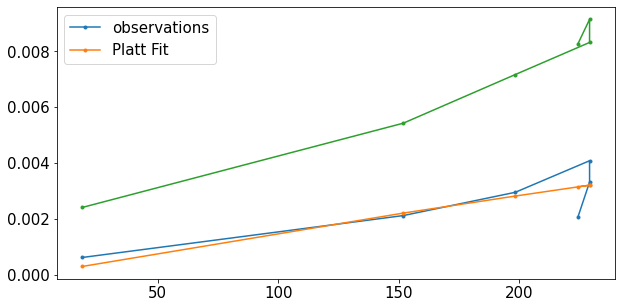

In [228]:
# Plot
fig,axs=plt.subplots(figsize=(10,5))
axs.plot(x,y,marker='.', label="observations")
axs.plot(x,fit_platt,marker='.', label='Platt Fit')
axs.plot(x, day2['culture_PP'],marker='.')
axs.legend()

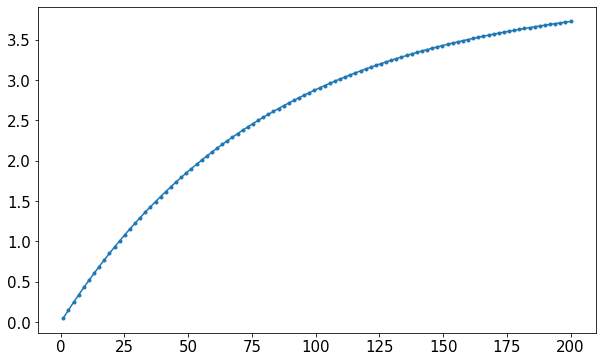

In [187]:
simulated_par=np.linspace(1,200,100)
simulated_pe=exponential_pe(simulated_par ,init_pmax, init_alpha)

fig,axs=plt.subplots(figsize=(10,6))
axs.plot(simulated_par, simulated_pe, marker='.')

In [165]:
x

11     18.735969
12    151.809734
13    198.267329
14    229.050383
15    229.061998
16    224.171493
Name: par, dtype: float64

In [193]:
init_pmax*(1-math.e**(-init_alpha*1/init_pmax))

0.04969477424727151

In [179]:
init_pmax

4.078645724891597

In [182]:
4*(1-math.e**(-0.05*20/4))

0.8847968677143805

### PLATT MODEL STUFF

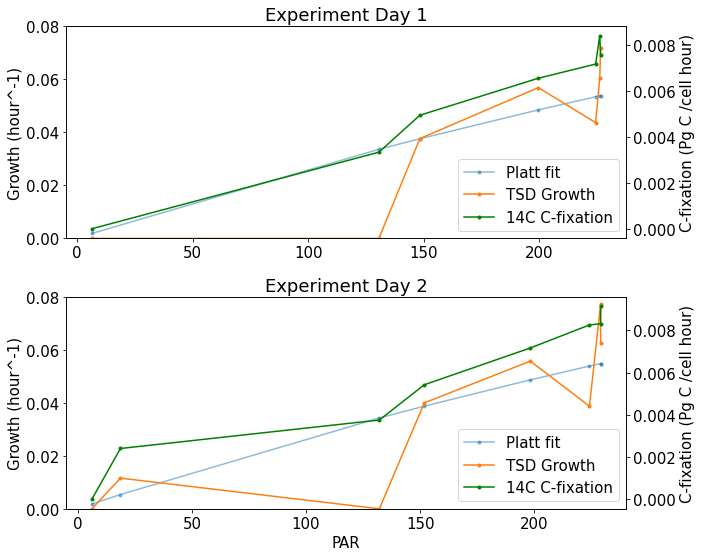

In [380]:
# look at day1
fit,params=optimize_pi(day1['par'],day1['adj_growth'],'platt1')
day1['platt2']=fit
# sort data
day1=day1.sort_values(by='par')

fig,axs=plt.subplots(nrows=2,ncols=1,figsize=(10,8))
# plot fit
ln1=axs[0].plot(day1['par'],day1['platt2'],marker='.',label='Platt fit',alpha=0.5)
# plot data
ln2=axs[0].plot(day1['par'],day1['adj_growth'],marker='.',label='TSD Growth')
# plot PP on secondary axis
twinax=axs[0].twinx()
ln3=twinax.plot(day1['par'],day1['culture_PP'],marker='.',label='14C C-fixation', color='green')
# make legend
lns=ln1+ln2+ln3
labs = [l.get_label() for l in lns]
axs[0].legend(lns, labs,loc='lower right')
axs[0].set_title('Experiment Day 1')
axs[0].set_ylabel('Growth (hour^-1)')
axs[0].set_ylim(0,0.08)
twinax.set_ylabel('C-fixation (Pg C /cell hour)')

# plot fit
ln1=axs[1].plot(day2['par'],day2['platt2'],marker='.',label='Platt fit',alpha=0.5)
# plot data
ln2=axs[1].plot(day2['par'],day2['adj_growth'],marker='.',label='TSD Growth')
# plot PP on secondary axis
twinax=axs[1].twinx()
ln3=twinax.plot(day2['par'],day2['culture_PP'],marker='.',label='14C C-fixation', color='green')
# make legend
lns=ln1+ln2+ln3
labs = [l.get_label() for l in lns]
axs[1].legend(lns, labs,loc='lower right')
axs[1].set_title('Experiment Day 2')
axs[1].set_xlabel('PAR')
axs[1].set_ylabel('Growth (hour^-1)')
axs[1].set_ylim(0,0.08)
twinax.set_ylabel('C-fixation (Pg C /cell hour)')

plt.tight_layout()

Text(0.5, 1.0, 'Experiment Day 2')

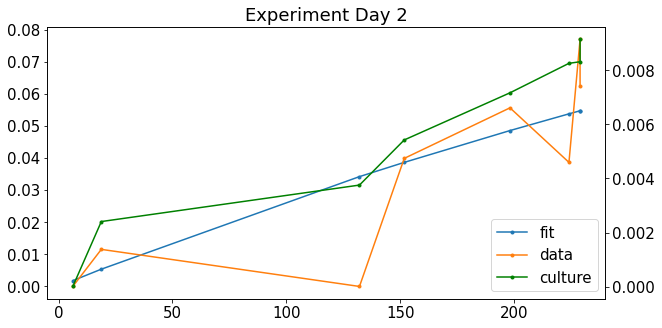

In [356]:
# look at day2
fit,params=optimize_pi(day2['par'],day2['adj_growth'],'platt1')
day2['platt2']=fit
# sort data
day2=day2.sort_values(by='par')
fig,axs=plt.subplots(figsize=(10,5))

# plot fit
ln1=axs[1].plot(day2['par'],day2['platt2'],marker='.',label='fit')
# plot data
ln2=axs[1].plot(day2['par'],day2['adj_growth'],marker='.',label='data')
# plot PP on secondary axis
twinax=axs[1].twinx()
ln3=twinax.plot(day2['par'],day2['culture_PP'],marker='.',label='culture', color='green')
# make legend
lns=ln1+ln2+ln3
labs = [l.get_label() for l in lns]
axs[1].legend(lns, labs,loc='lower right')
axs[1].set_title('Experiment Day 2')